# Vertex Forecast: Retail Demand Pipelines with M5

### Retail demand forecasting with Vertex Forecast and Pipelines

This notebook demonstrates the use of Vertex Pipelines to orchestrate Vertex Forecast (VF) workflows. It makes use of three tables that define the retail demand schema for this example:

**Dataset**
* Uses the M5 public dataset
* See the [M5 Dataprep Notebook](https://colab.research.google.com/drive/1rjff9GVdjP--go_V9v2hV_heIFMtX3Mc?usp=sharing) for step-by-step instructions for downloading and preparing the M5 dataset

**Tables in the dataset**
- **activity**: activity table, containing time-variant information, e.g., sales, promo, etc.
- **product**: the product table containing metadata of items
- **plan table**: the table used to generate forecasts for future periods where actuals are unknown

**Modeling approach**
* Two models are trained, each with a different optimization objective: `minimize-rmse` & `minimize-mape`
* The predictions from both models aere stacked (averaged), to produce the final prediction
* In the training job configuration, `additional_experiments` is used to specify two overrides:
> * `'forecasting_model_type_override': 'seq2seq'` - instructs VF to only train a sequence-to-sequence model
> * `'forecasting_hierarchical_group_column_names':'dept_id, cat_id'` - specifies hierarchical modeling, and which input features to aggregate

**Model Pipeline**
* This pipeline includes all steps needed to train and evlauate the models, as well as generate a forecast/prediction for the future
* It includes examples of custom pipeline components and pre-built components from Vertex AI


## Notebook Setup

**Tip:** search for `TODO` to find variables/parameters to specify

In [1]:
PROJECT_ID = 'hybrid-vertex'  # <--- TODO: CHANGE THIS
LOCATION = 'us-central1'
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


### Colab stuff

**If running this notebook in Colab**, authenticate with user account:

In [2]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()
    
if 'google.colab' in sys.modules:
    USER_FLAG = ''
else:
    USER_FLAG = '--user'

#### Install KFP SDK and Vertex Pipelines client library

In [4]:
# # New
# ! pip install -U google-cloud-storage $USER_FLAG
# ! pip install $USER_FLAG kfp google-cloud-pipeline-components --upgrade
# # !git clone https://github.com/kubeflow/pipelines.git
# # !pip install pipelines/components/google-cloud/.
# !pip -q install $USER_FLAG --upgrade google-cloud-aiplatform

# # Automatically restart kernel after installs
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [6]:
# import sys
# if 'google.colab' in sys.modules:
#     PROJECT_ID = 'hybrid-vertex'  # <--- TODO: CHANGE THIS
#     !gcloud config set project {PROJECT_ID}
#     from google.colab import auth
#     auth.authenticate_user()
#     USER_FLAG = ''

Check the versions of the installed packages
* KFP SDK version should be >=1.8.9
* GCP components should be >= 0.2.1

In [5]:
! python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"
! python3 -c "import google_cloud_pipeline_components; print('google_cloud_pipeline_components version: {}'.format(google_cloud_pipeline_components.__version__))"

KFP SDK version: 1.8.18
google_cloud_pipeline_components version: 1.0.36


## Pipeline Configuration

### Set some variables

**Before you run the next cell**, **edit it** to set variables for your project.

* For `BUCKET_NAME`, enter the name of a Cloud Storage (GCS) bucket in your project.  Don't include the `gs://` prefix.

GCP Project Configuration

In [2]:
# GCP Project Configuration:
# project where pipeline and vertex jobs are executed

GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
REGION = 'us-central1'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"REGION: {REGION}")

assert LOCATION, 'the value for this variable must be set'
assert PROJECT_ID, 'the value for this variable must be set'
# assert PROJECT_NUMBER, 'the value for this variable must be set'

%env GOOGLE_CLOUD_PROJECT={PROJECT_ID}

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
REGION: us-central1
env: GOOGLE_CLOUD_PROJECT=hybrid-vertex


Required Pipeline Parameters

Packages

In [3]:
# packages
from datetime import datetime
import json
import os
import time
from typing import Any, Callable, Dict, NamedTuple, Optional
import pandas as pd

# visualization
# from matplotlib import dates as mdates
# from matplotlib import pyplot as plt
# import seaborn as sns

from IPython.display import Image, clear_output
from IPython.core.display import HTML

# colab
# from google import auth
# from google.colab import auth as colab_auth
# from google.colab import drive

# google cloud
from google.api_core import exceptions as google_exceptions
from google_cloud_pipeline_components import aiplatform as gcc_aip
from google_cloud_pipeline_components.experimental import forecasting as gcc_aip_forecasting
import google.cloud.aiplatform as vertex_ai
from google.cloud import bigquery
from google.cloud import storage

# kfp
import kfp
import kfp.v2.dsl
from kfp.v2.google import client as pipelines_client
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component)

In [4]:
print(f'vertex_ai SDK version: {vertex_ai.__version__}')
print(f'bigquery SDK version: {bigquery.__version__}')

vertex_ai SDK version: 1.21.0
bigquery SDK version: 2.34.4


BQ and pipeline clients

In [5]:
# colab
# from google import auth
# from google.colab import auth as colab_auth
# from google.colab import drive

# colab_auth.authenticate_user()

# SCOPES = (
#   'https://www.googleapis.com/auth/cloud-platform',
# )

# credentials, _ = auth.default()
# credentials, _ = auth.default(scopes=SCOPES, quota_project_id=PROJECT_ID)

### Setup SDK Clients

In [6]:
bq_client = bigquery.Client(
    project=PROJECT_ID, 
    # credentials=credentials
)

storage_client = storage.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID,
    location=REGION
)

# Training, Evaluation, and Forecast Pipeline

### Pipeline visualization in Vertex UI

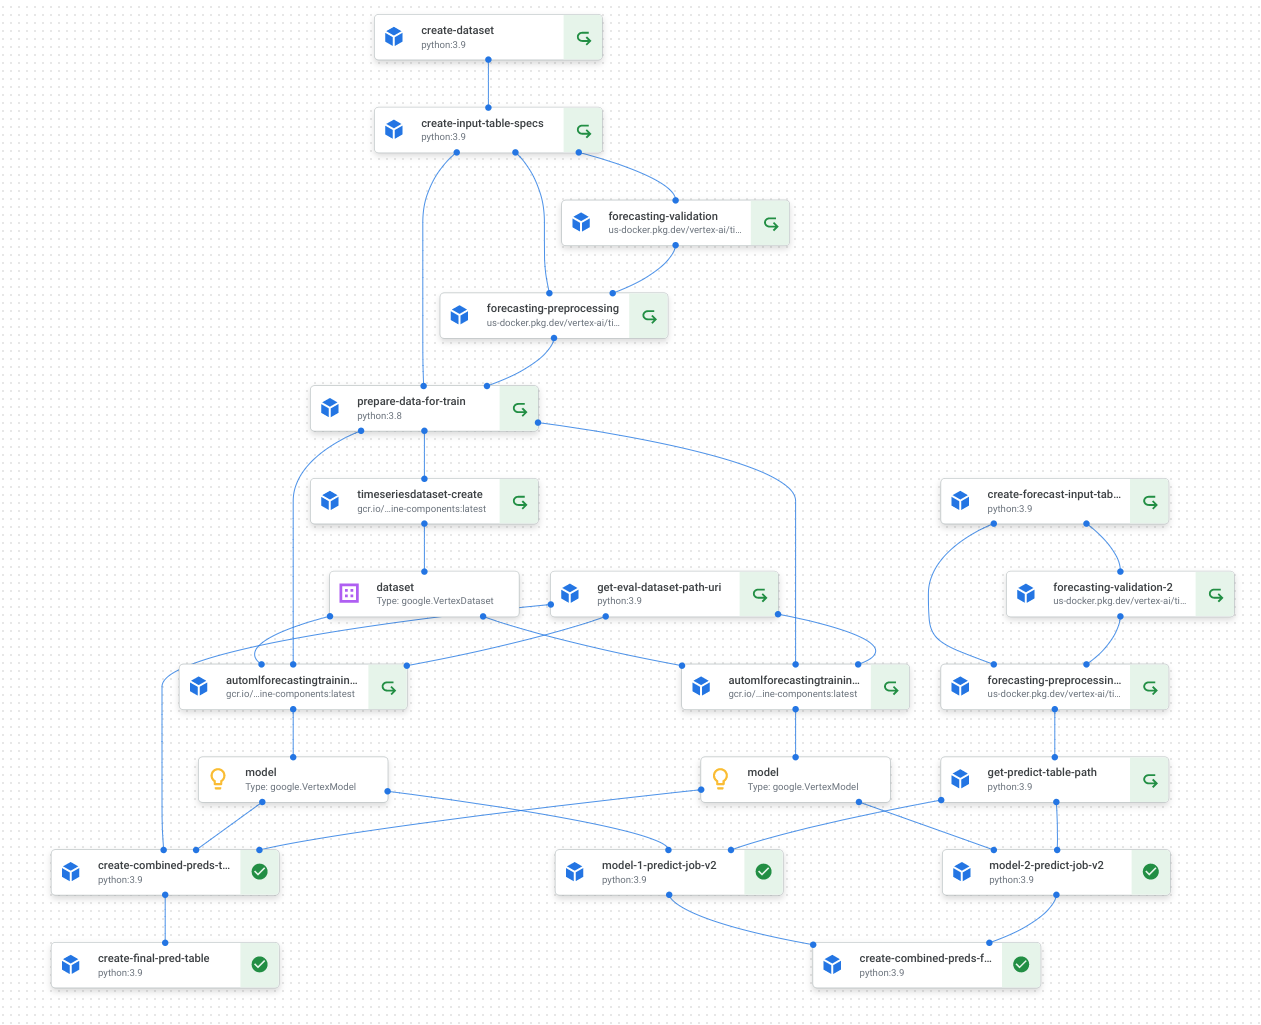

## Components

In [212]:
REPO_DOCKER_PATH_PREFIX = 'src'

! rm -rf $REPO_DOCKER_PATH_PREFIX
! mkdir $REPO_DOCKER_PATH_PREFIX
# !mkdir -p ./$REPO_DOCKER_PATH_PREFIX

### Pipeline Component: **Create BQ dataset**

Creates BQ dataset, if one doesnt exist

In [213]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/create_bq_dataset.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(
  base_image='python:3.9',
  packages_to_install=['google-cloud-bigquery==2.34.4'],
)
def create_bq_dataset(
    project: str,
    vertex_dataset: str,
    new_bq_dataset: str,
    bq_location: str
) -> NamedTuple('Outputs', [
    ('bq_dataset_name', str),
    ('bq_dataset_uri', str),
]):
    
    from google.cloud import bigquery

    bq_client = bigquery.Client(project=project, location='US') # bq_location)
    (
      bq_client.query(f'CREATE SCHEMA IF NOT EXISTS `{project}.{new_bq_dataset}`')
      .result()
    )
    
    return (
        f'{new_bq_dataset}',
        f'bq://{project}:{new_bq_dataset}',
    )

Writing src/create_bq_dataset.py


### Pipeline component: **Input Table Specs**

Note
* `time_granularity_unit` - eligible unit values are: MINUTE, HOUR, DAY, WEEK, MONTH, YEAR

In [214]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/create_input_table_specs.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(
    base_image='python:3.9'
)
def create_input_table_specs(
    products_table_uri: str,
    activities_table_uri: str,
    locations_table_uri: str,
    time_granularity_unit: str,
    time_granularity_quantity: int,
    # train_data_bq_source: str,
) -> NamedTuple('Outputs', [
    ('input_table_specs', str),
    ('model_feature_columns', str),
    # ('train_data_source_bq_uri', str),
]):
    
    import json
    import logging
    logging.getLogger().setLevel(logging.INFO)

    # train_data_source_bq_uri = f'bq://{train_data_bq_source}'

    products_table_specs = {
        'bigquery_uri': products_table_uri,
        'table_type': 'FORECASTING_ATTRIBUTE',
        'forecasting_attribute_table_metadata': {
            'primary_key_column': 'product_id'
        }
    }

    locations_table_specs = {
        'bigquery_uri': locations_table_uri,
        'table_type': 'FORECASTING_ATTRIBUTE',
        'forecasting_attribute_table_metadata': {
            'primary_key_column': 'location_id'
        }
    }

    activities_table_specs = {
        'bigquery_uri': activities_table_uri,
        'table_type': 'FORECASTING_PRIMARY',
        'forecasting_primary_table_metadata': {
            'time_column': 'date',
            'target_column': 'gross_quantity',
            'time_series_identifier_columns': ['product_id', 'location_id'],
            'unavailable_at_forecast_columns': [],
            'time_granularity': {
                'unit': time_granularity_unit,
                'quantity': time_granularity_quantity,
            },
            # 'predefined_splits_column': 'ml_use',
            # 'predefined_split_column': 'ml_use', # model_override
        }
    }

    model_feature_columns = [
        'product_id',
        'location_id',
        'gross_quantity',
        'date',
        'weekday',
        'wday',
        'month',
        'year',
        'event_name_1',
        'event_type_1',
        'event_name_2',
        'event_type_2',
        'snap_CA',
        'snap_TX'
        'snap_WI',
        'dept_id',
        'cat_id',
        'state_id',
    ]

    input_table_specs = [
    activities_table_specs,
    products_table_specs,
    locations_table_specs,
    ]

    return (
        json.dumps(input_table_specs),  # input_table_specs
        json.dumps(model_feature_columns),  # model_feature_columns
        # f'{train_data_source_bq_uri}',
    )

Writing src/create_input_table_specs.py


### Pipeline Component: Get Eval Dataset uri

In [215]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/get_eval_dataset_path_uri.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(base_image='python:3.9')
def get_eval_dataset_path_uri(
    project: str,
    eval_bq_dataset: str,
    model_1_table: str,
    model_2_table: str,
) -> NamedTuple('Outputs',[
    ('model_1_bigquery_table_uri', str),
    ('model_2_bigquery_table_uri', str),
    ('eval_bq_dataset', str),
]):
    
    import json
    import logging

    model_1_table_path_name = f'{project}:{eval_bq_dataset}:eval-{model_1_table}'
    model_2_table_path_name = f'{project}:{eval_bq_dataset}:eval-{model_2_table}'

    logging.info(model_1_table_path_name)
    logging.info(model_2_table_path_name)

    return (
        f'bq://{model_1_table_path_name}',
        f'bq://{model_2_table_path_name}',
        f'{eval_bq_dataset}',
    )

Writing src/get_eval_dataset_path_uri.py


### Pipeline component: combine model predictions

In [216]:
# from typing import Dict, List, Optional, Sequence, Tuple, Union

In [217]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/create_combined_preds_table.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(
  base_image='python:3.9',
  packages_to_install=[
      'google-cloud-bigquery==2.34.4', 
      'google-cloud-aiplatform==1.21.0'
  ],
)
def create_combined_preds_table(
  project: str,
  dataset: str,
  bq_location: str,
  model_1_eval_table_uri: str,
  model_2_eval_table_uri: str,
  model_1_path: Input[Artifact],
  model_2_path: Input[Artifact],
  override: str = 'False',
) -> NamedTuple('Outputs', [
    ('combined_preds_table_uri', str),
    ('eval_bq_dataset', str),
]):
    
    from google.cloud import bigquery

    override = bool(override)
    
    bq_client = bigquery.Client(
        project=project, 
        location="US", # bq_location
    )
    
    combined_preds_table_name = f'{project}.{dataset}.combined_preds'

    model_1_eval_table_uri=model_1_eval_table_uri
    model_2_eval_table_uri=model_2_eval_table_uri

    def _sanitize_bq_uri(bq_uri):
        if bq_uri.startswith("bq://"):
            bq_uri = bq_uri[5:]
        return bq_uri.replace(":", ".")

    model_1_eval_table_uri = _sanitize_bq_uri(
        model_1_eval_table_uri
    )

    model_2_eval_table_uri = _sanitize_bq_uri(
        model_2_eval_table_uri
    )

    (
        bq_client.query(
            f"""
            CREATE {'OR REPLACE TABLE' if override else 'TABLE IF NOT EXISTS'}
                `{combined_preds_table_name}`
            AS (
                SELECT * except(row_number) from
                (
                  SELECT *,ROW_NUMBER() OVER (PARTITION BY datetime,vertex__timeseries__id order by predicted_on_date asc) row_number
                  FROM
                (
                  SELECT
                  DATE(table_a.date) as datetime,
                  DATE(table_a.predicted_on_date) as predicted_on_date,
                  CAST(table_a.gross_quantity as INTEGER) as gross_quantity,
                  table_a.vertex__timeseries__id,
                  table_a.predicted_gross_quantity.value as predicted_gross_quantity_a,
                  table_b.predicted_gross_quantity.value as predicted_gross_quantity_b
                  FROM
                  `{model_1_eval_table_uri}` AS table_a
                  INNER JOIN `{model_2_eval_table_uri}` AS table_b
                  ON DATE(table_a.date) = DATE(table_b.date)
                  and table_a.vertex__timeseries__id = table_b.vertex__timeseries__id
                  and DATE(table_a.predicted_on_date) = DATE(table_b.predicted_on_date)
                ) a
              )m
              where row_number = 1
            );
          """
        )
        .result()
    )

    return (
        f'bq://{combined_preds_table_name}',
        f'{dataset}',
    )

Writing src/create_combined_preds_table.py


### Pipeline ComponentL create final pred table

In [218]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/create_final_pred_table.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(
  base_image='python:3.9',
  packages_to_install=[
      'google-cloud-bigquery==2.34.4'
  ],
)
def create_final_pred_table(
    project: str,
    dataset: str,
    bq_location: str,
    combined_preds_table_uri: str,
    override: str = 'False',
) -> NamedTuple('Outputs', [
    ('final_preds_table_uri', str),
]):
    from google.cloud import bigquery

    override = bool(override)
    
    bq_client = bigquery.Client(
        project=project, 
        location="US", # bq_location
    )
    
    final_preds_table_name = f'{project}.{dataset}.final_preds'
    
    (
        bq_client.query(
            f"""
            CREATE {'OR REPLACE TABLE' if override else 'TABLE IF NOT EXISTS'}
                `{final_preds_table_name}`
            AS (
              SELECT
                  datetime,
                  vertex__timeseries__id,
                  gross_quantity as gross_quantity_actual,
                  ROUND(a.predicted_gross_quantity_a, 2) as model_a_pred,
                  ROUND(a.predicted_gross_quantity_b, 2) as model_b_pred,
                  ROUND((a.predicted_gross_quantity_a + a.predicted_gross_quantity_b)/2, 2) AS Final_Pred,
                  ROUND(ABS(gross_quantity - ((a.predicted_gross_quantity_a + a.predicted_gross_quantity_b)/2)), 2) as Final_Pred_error,
              FROM
                `{combined_preds_table_uri[5:]}` AS a);
            """
        )
        .result()
    )

    return (
      f'bq://{final_preds_table_name}',
    )

Writing src/create_final_pred_table.py


### Pipeline component: Create Forecast input table

In [219]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/create_forecast_input_table_specs.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(
    base_image='python:3.9',
    packages_to_install=[
        'google-cloud-aiplatform==1.21.0'
    ],
)
def create_forecast_input_table_specs(
  project: str,
  forecast_products_table_uri: str,
  forecast_activities_table_uri: str,
  forecast_locations_table_uri: str,
  forecast_plan_table_uri: str,
  time_granularity_unit: str,
  time_granularity_quantity: int,
) -> NamedTuple('Outputs', [
    ('forecast_input_table_specs', str)
]):
    import json
    import os
    import logging
    logging.getLogger().setLevel(logging.INFO)

    forecast_input_table_specs = [
        {
            'bigquery_uri': forecast_plan_table_uri,
            'table_type': 'FORECASTING_PLAN',
        },
        {
            'bigquery_uri': forecast_activities_table_uri,
            'table_type': 'FORECASTING_PRIMARY',
            'forecasting_primary_table_metadata': {
                'time_column': 'date',
                'target_column': 'gross_quantity',
                'time_series_identifier_columns': ['product_id', 'location_id'],
                'unavailable_at_forecast_columns': [],
                'time_granularity': {
                    'unit': time_granularity_unit,
                    'quantity': time_granularity_quantity,
                },
                # 'predefined_splits_column': 'ml_use',
                # 'predefined_split_column': 'ml_use', # model_override
            }
        },
        {
            'bigquery_uri': forecast_products_table_uri,
            'table_type': 'FORECASTING_ATTRIBUTE',
            'forecasting_attribute_table_metadata': {
                'primary_key_column': 'product_id'
            }
        },
        {
            'bigquery_uri': forecast_locations_table_uri,
            'table_type': 'FORECASTING_ATTRIBUTE',
            'forecasting_attribute_table_metadata': {
                'primary_key_column': 'location_id'
            }
        },
    ]

    logging.info(f"forecast_input_table_specs: {forecast_input_table_specs}")

    return (
        json.dumps(forecast_input_table_specs),
    )

Writing src/create_forecast_input_table_specs.py


### Pipeline Component: Get predict table path

In [220]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/get_predict_table_path.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(
    base_image='python:3.9'
)
def get_predict_table_path(
    predict_processed_table: str
) -> NamedTuple('Outputs', [
    ('preprocess_bq_uri', str)
]):
    
    import json
    import logging

    logging.info(f"predict_processed_table: {predict_processed_table}")
    
    preprocess_bq_uri = (
        json.loads(predict_processed_table)
        ['processed_bigquery_table_uri']
    )
    
    logging.info(f"preprocess_bq_uri: {preprocess_bq_uri}")
    
    return (
        f'{preprocess_bq_uri}',
    )

Writing src/get_predict_table_path.py


### Pipeline Component: get model path

In [221]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/get_model_path.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(
    base_image='python:3.9',
    packages_to_install=[
        'google-cloud-aiplatform==1.21.0'
    ],
)
def get_model_path(
    project: str,
    location: str,
    model: Input[Artifact],
) -> NamedTuple('Outputs', [
    ('model_resource_path', str)
]):
    
    from google.cloud import aiplatform as vertex_ai
    import json
    import logging

    vertex_ai.init(
        project=project,
        location=location,
    )

    model_resource_path = model.metadata["resourceName"]
    logging.info("model path: %s", model_resource_path)
    
    return (
        model_resource_path,
    )

Writing src/get_model_path.py


### Pipeline Component: model_batch_prediction_job

In [222]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/model_batch_prediction_job.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(
    base_image='python:3.9',
    packages_to_install=[
        'google-cloud-aiplatform==1.21.0'
    ],
)
def model_batch_prediction_job(
    project: str,
    location: str,
    eval_bq_dataset: str,
    bigquery_source: str,
    model_name: str,
    model_1_path: Input[Artifact],
) -> NamedTuple('Outputs', [
    ('batch_predict_output_bq_uri', str),
    ('batch_predict_job_dict', dict)
]):

    from google.cloud import aiplatform as vertex_ai
    import json
    import logging

    vertex_ai.init(
        project=project,
        location=location,
    )

    model_resource_path = model_1_path.metadata["resourceName"]
    logging.info("model path: %s", model_resource_path)

    model = vertex_ai.Model(model_name=model_resource_path)
    logging.info("Model dict:", model.to_dict())

    batch_predict_job = model.batch_predict(
        bigquery_source=bigquery_source,
        instances_format="bigquery",
        bigquery_destination_prefix=f'bq://{project}.{eval_bq_dataset}',
        predictions_format="bigquery",
        job_display_name=f'bpj-{model_name}',
    )

    batch_predict_bq_output_uri = "{}.{}".format(
      batch_predict_job.output_info.bigquery_output_dataset,
      batch_predict_job.output_info.bigquery_output_table
    )

    logging.info(batch_predict_job.to_dict())
    
    return (
        batch_predict_bq_output_uri,
        batch_predict_job.to_dict(),
    )

Writing src/model_batch_prediction_job.py


#### TODO: remove duplicate batch prediction component

In [223]:
# %%writefile {REPO_DOCKER_PATH_PREFIX}/model_2_predict_job_v2.py

# import kfp
# from typing import Any, Callable, Dict, NamedTuple, Optional, List
# from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
#                         OutputPath, component, Metrics)

# @kfp.v2.dsl.component(
#   base_image='python:3.9',
#   packages_to_install=['google-cloud-aiplatform==1.21.0'],
# )
# def model_2_predict_job_v2(
#     project: str,
#     location: str,
#     eval_bq_dataset: str,
#     bigquery_source: str,
#     model_2_path: Input[Artifact],
# ) -> NamedTuple('Outputs', [
#                             ('batch_predict_output_bq_uri', str),
#                             ('batch_predict_job_dict', dict)]):

#   from google.cloud import aiplatform as vertex_ai
#   # from google_cloud_pipeline_components.types import artifact_types
#   import json
#   import logging

#   vertex_ai.init(
#       project=project,
#       location=location,
#   )
#   # print("model_2_path:", model_2_path)
#   # model_aip_uri=model_2_path["uri"]
#   # print("model_2_path[49:]:", model_2_path[49:])
#   # model_aip_uri=model_2_path[49:]
#   # print("model_aip_uri_2:", model_aip_uri)

#   # model = artifact_types.VertexModel(uri='xxx')

#   model_resource_path = model_2_path.metadata["resourceName"]
#   logging.info("model path: %s", model_resource_path)

#   model = vertex_ai.Model(model_name=model_resource_path)
#   print("Model dict:", model.to_dict())

#   batch_predict_job = model.batch_predict(
#       bigquery_source=bigquery_source,
#       instances_format="bigquery",
#       bigquery_destination_prefix=f'bq://{project}.{eval_bq_dataset}',
#       predictions_format="bigquery",
#       job_display_name='batch-predict-job-2',
#   )

#   batch_predict_bq_output_uri = "{}.{}".format(
#       batch_predict_job.output_info.bigquery_output_dataset,
#       batch_predict_job.output_info.bigquery_output_table)

#   # if batch_predict_bq_output_uri.startswith("bq://"):
#   #   batch_predict_bq_output_uri = batch_predict_bq_output_uri[5:]

#   # batch_predict_bq_output_uri.replace(":", ".")

#   print(batch_predict_job.to_dict())
#   return (batch_predict_bq_output_uri,
#           batch_predict_job.to_dict())

### Pipeline Component: Combine Plan Predictions

In [224]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/create_combined_preds_forecast_table.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(
    base_image='python:3.9',
    packages_to_install=[
        'google-cloud-bigquery==2.34.4'
  ],
)
def create_combined_preds_forecast_table(
  project: str,
  dataset: str,
  model_1_pred_table_uri: str,
  model_2_pred_table_uri: str,
  override: str = 'False',
) -> NamedTuple('Outputs', [
    ('combined_preds_forecast_table_uri', str)
]):
    
    from google.cloud import bigquery

    override = bool(override)
    bq_client = bigquery.Client(project=project)
    combined_preds_forecast_table_name = f'{project}.{dataset}.combined_preds_forecast'
    (
        bq_client.query(
            f"""
            CREATE {'OR REPLACE TABLE' if override else 'TABLE IF NOT EXISTS'}
                `{combined_preds_forecast_table_name}`
            AS (
              SELECT
                table_a.date as date,
                table_a.vertex__timeseries__id,
                ROUND(table_a.predicted_gross_quantity.value,2) as predicted_gross_quantity_a,
                ROUND(table_b.predicted_gross_quantity.value, 2) as predicted_gross_quantity_b,
                ROUND((table_a.predicted_gross_quantity.value + table_b.predicted_gross_quantity.value)/2, 2) AS Final_Pred
              FROM
                `{model_1_pred_table_uri[5:]}` AS table_a
              INNER JOIN `{model_2_pred_table_uri[5:]}` AS table_b
              ON table_a.date = table_b.date
              AND table_a.vertex__timeseries__id = table_b.vertex__timeseries__id
            );
          """
        )
        .result()
    )

    return (
        f'bq://{combined_preds_forecast_table_name}',
    )

Writing src/create_combined_preds_forecast_table.py


### pipeline component: args_generator

In [225]:
%%writefile {REPO_DOCKER_PATH_PREFIX}/args_generator_op_1.py

import kfp
from typing import Any, Callable, Dict, NamedTuple, Optional, List
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output,
                        OutputPath, component, Metrics)

@kfp.v2.dsl.component(
    base_image='python:3.9',
    packages_to_install=[
        'google-cloud-aiplatform==1.21.0'
    ],
)
def args_generator_op_1(
    project: str,
    location: str,
    rmse_model: Input[Artifact],
    rmse_display_name: str,
    mape_model: Input[Artifact],
    mape_display_name: str,
# ) -> str:
) -> NamedTuple('Outputs', [
    ('model_list', list)
]):

    from google.cloud import aiplatform as vertex_ai
    import json
    import logging

    vertex_ai.init(
        project=project,
        location=location,
    )

    rmse_model_resource_path = rmse_model.metadata["resourceName"]
    logging.info(f"rmse_model_resource_path: {rmse_model_resource_path}")
    
    mape_model_resource_path = mape_model.metadata["resourceName"]
    logging.info(f"mape_model_resource_path: {mape_model_resource_path}")
    
    model_list = [rmse_model_resource_path, mape_model_resource_path]
    logging.info(f"model_list: {model_list}")
    
    test_list = [
        {
            "model": rmse_model_resource_path, 
            "objective": "rmse", 
        },
        {
            "model": mape_model_resource_path, 
            "objective": "mape", 
        }
    ]
    logging.info(f"test_list: {test_list}")

    return (
        model_list,
    )
        
        
    #     json.dumps(
    #     [
    #         {
    #             "model": rmse_model_resource_path, 
    #             "objective": "rmse", 
    #             # "display_name": rmse_display_name
    #         }, 
    #         {
    #             "model": mape_model_resource_path, 
    #             "objective": "mape", 
    #             # "display_name": mape_display_name
    #         }
    #     ],
    #     sort_keys=True,
    # )

Writing src/args_generator_op_1.py


# Build, Compile, & Run Pipeline

**Docs**

`AutoMLForecastingTrainingJobRunOp()`

* [Pipeline Component Docs](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.1.7/google_cloud_pipeline_components.aiplatform.html)
* [Source Code](https://github.com/googleapis/python-aiplatform/blob/e7bf0d83d8bb0849a9bce886c958d13f5cbe5fab/google/cloud/aiplatform/training_jobs.py) search for `class AutoMLForecastingTrainingJob`


In [226]:
VERSION = 'v11'

## Vertex Experiments

In [227]:
EXPERIMENT_PREFIX = 'm5-pipe-cleanup'                     # custom identifier for organizing experiments
EXPERIMENT_NAME=f'{EXPERIMENT_PREFIX}'
RUN_NAME = f'run-{time.strftime("%Y%m%d-%H%M%S")}'

print(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
print(f"RUN_NAME: {RUN_NAME}")

EXPERIMENT_NAME: m5-pipe-cleanup
RUN_NAME: run-20230201-123940


## Pipeline vars

In [228]:
BUCKET_NAME = 'vertex-forecast-22'
GCS_BUCKET_URI =f'gs://{BUCKET_NAME}'

EXPERIMENT_GCS_DIR = f'gs://{BUCKET_NAME}/{EXPERIMENT_NAME}/{VERSION}'

# Stores pipeline executions for each run
PIPELINE_ROOT_PATH = f'{EXPERIMENT_GCS_DIR}/pipeline_root'
print(f'PIPELINE_ROOT_PATH: {PIPELINE_ROOT_PATH}')

PIPELINE_TAG = 'train'
PIPELINE_NAME = f'{PIPELINE_TAG}-{EXPERIMENT_NAME}-{VERSION}'.replace('_', '-')
print(f"PIPELINE_NAME: {PIPELINE_NAME}")

PIPELINE_ROOT_PATH: gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root
PIPELINE_NAME: train-m5-pipe-cleanup-v11


In [230]:
from src import (
    create_bq_dataset,create_input_table_specs, get_eval_dataset_path_uri,
    create_combined_preds_table, create_forecast_input_table_specs, get_predict_table_path,
    model_batch_prediction_job, create_combined_preds_forecast_table, get_model_path,
    create_final_pred_table, args_generator_op_1
)

@kfp.v2.dsl.pipeline(
  name=PIPELINE_NAME
)
def pipeline(
    vertex_project: str,
    location: str,
    version: str,
    data_source_dataset: str,
    eval_destination_dataset: str,
    preprocess_dataset_us: str,
    locations_table_uri: str,
    forecast_locations_table_uri: str,
    products_override: str,
    products_table_uri: str,
    forecast_products_table_uri: str,
    activities_override: str,
    activities_table_uri: str,
    forecast_activities_table_uri: str,
    # activities_expected_historical_last_date: str,
    forecast_plan_table_uri: str,
    time_granularity_unit: str,
    time_granularity_quantity: int,
    context_window: int,
    forecast_horizon: int,
    override: str,
    gcs_root_dir: str,
    batch_predict_explanation_data_sample_size: int,
    target_column: str,
    generate_explanation: bool,
    model_evaluation_flag: str,
    forecast_plan_flag: str,
    combine_preds_flag: str,
    rmse_eval_flag: str,
    mape_eval_flag: str,
    eval_bq_processed: str,
    batch_predict_machine_type: str = "n1-standard-4",
    batch_predict_instances_format: str = 'bigquery',
    batch_predict_predictions_format: str = 'bigquery',
    budget_milli_node_hours: int = 16000,
    # json_string: str = json.dumps(
    #     [
    #         {
    #             "model": rmse_model_op.outputs['model'], 
    #             "objective": "rmse", 
    #             "display_name": rmse_model_version,
    #         },
    #         {
    #             "model": mape_model_op.outputs['model'],
    #             "objective": "mape", 
    #             "display_name": mape_model_version,
    #         }
    #     ],
    #     sort_keys=True,
    # )
):
    
    # create BQ dataset
    create_train_dataset_op = (
      create_bq_dataset.create_bq_dataset(
          project=vertex_project,
          vertex_dataset=data_source_dataset,
          new_bq_dataset=eval_destination_dataset,
          bq_location=location
      )
    )

    # ======================================
    # prep train jobs
    # ======================================

    create_input_table_specs_op = (
        create_input_table_specs.create_input_table_specs(
            products_table_uri=products_table_uri,
            activities_table_uri=activities_table_uri,
            locations_table_uri=locations_table_uri,
            time_granularity_unit=time_granularity_unit,
            time_granularity_quantity=time_granularity_quantity,
            # train_data_bq_source=train_data_bq_source,
        )
        .after(create_train_dataset_op)
    )

    forecasting_validation_op = (
        gcc_aip_forecasting.ForecastingValidationOp(
            input_tables=str(create_input_table_specs_op.outputs['input_table_specs']),
            validation_theme='FORECASTING_TRAINING',
      )
    )

    forecasting_preprocessing_op = (
      gcc_aip_forecasting.ForecastingPreprocessingOp(
          project=vertex_project,
          input_tables=str(create_input_table_specs_op.outputs['input_table_specs']),
          preprocessing_bigquery_dataset=data_source_dataset,
      )
      .after(forecasting_validation_op)
    )

    prepare_data_for_train_op = (
      gcc_aip_forecasting.ForecastingPrepareDataForTrainOp(
          input_tables=(
              str(create_input_table_specs_op.outputs['input_table_specs'])
          ),
          preprocess_metadata=(
              forecasting_preprocessing_op.outputs['preprocess_metadata']
          ),
          model_feature_columns=(
              str(create_input_table_specs_op.outputs['model_feature_columns'])
          )
      )
    )

    time_series_dataset_create_op = (
      gcc_aip.TimeSeriesDatasetCreateOp(
          display_name=f'train_ds_full_m5_{VERSION}',
          bq_source=prepare_data_for_train_op.outputs['preprocess_bq_uri'],
          project=vertex_project,
          location=location,
      )
    )

    mape_model_version = f'{VERSION}-seq2seq-mape'
    rmse_model_version = f'{VERSION}-seq2seq-rmse' 

    get_eval_dataset_path_uri_op = (
      get_eval_dataset_path_uri.get_eval_dataset_path_uri(
          project=vertex_project,
          eval_bq_dataset=create_train_dataset_op.outputs['bq_dataset_name'],
          model_1_table=mape_model_version,
          model_2_table=rmse_model_version,
      )
    )

    # ======================================
    # train jobs
    # ======================================

    # mape_model_op = gcc_aip_forecasting.ForecastingTrainingWithExperimentsOp(
    mape_model_op = (
      gcc_aip.AutoMLForecastingTrainingJobRunOp(
          display_name=f'train-{mape_model_version}',
          model_display_name=mape_model_version,
          model_labels={'model_override' : 'se2seq-hier'}, # model_override : se2seq-hier, tft
          # model_labels={'model_type' : 'l2l'},
          dataset=time_series_dataset_create_op.outputs['dataset'],
          context_window=context_window,
          forecast_horizon=forecast_horizon,
          budget_milli_node_hours=budget_milli_node_hours,
          project=vertex_project,
          location=location,
          export_evaluated_data_items=True,
          export_evaluated_data_items_bigquery_destination_uri=get_eval_dataset_path_uri_op.outputs['model_1_bigquery_table_uri'], # must be format:``bq://<project_id>:<dataset_id>:<table>``
          export_evaluated_data_items_override_destination=True,
          target_column=prepare_data_for_train_op.outputs['target_column'],
          time_column=prepare_data_for_train_op.outputs['time_column'],
          time_series_identifier_column=prepare_data_for_train_op.outputs['time_series_identifier_column'],
          time_series_attribute_columns=prepare_data_for_train_op.outputs['time_series_attribute_columns'],
          unavailable_at_forecast_columns=prepare_data_for_train_op.outputs['unavailable_at_forecast_columns'],
          available_at_forecast_columns=prepare_data_for_train_op.outputs['available_at_forecast_columns'],
          data_granularity_unit=prepare_data_for_train_op.outputs['data_granularity_unit'],
          data_granularity_count=prepare_data_for_train_op.outputs['data_granularity_count'],
          predefined_split_column_name= '', # prepare_data_for_train_op.outputs['predefined_split_column'],
          column_transformations=prepare_data_for_train_op.outputs['column_transformations'],
          weight_column=prepare_data_for_train_op.outputs['weight_column'],
          optimization_objective='minimize-mape',
          additional_experiments={
              'forecasting_model_type_override': 'seq2seq',
              'forecasting_hierarchical_group_column_names':'dept_id, cat_id'},
      )
    )

    # rmse_model_op = gcc_aip_forecasting.ForecastingTrainingWithExperimentsOp(
    rmse_model_op = (
      gcc_aip.AutoMLForecastingTrainingJobRunOp(
          display_name=f'train-{rmse_model_version}',
          model_display_name=rmse_model_version,
          model_labels={'model_override' : 'se2seq-hier'}, # model_override : se2seq-hier, tft
          # model_labels={'model_type' : 'l2l'},
          dataset=time_series_dataset_create_op.outputs['dataset'],
          context_window=context_window,
          forecast_horizon=forecast_horizon,
          budget_milli_node_hours=budget_milli_node_hours,
          project=vertex_project,
          location=location,
          export_evaluated_data_items=True,
          export_evaluated_data_items_bigquery_destination_uri=get_eval_dataset_path_uri_op.outputs['model_2_bigquery_table_uri'],
          export_evaluated_data_items_override_destination=True,
          target_column=prepare_data_for_train_op.outputs['target_column'],
          time_column=prepare_data_for_train_op.outputs['time_column'],
          time_series_identifier_column=prepare_data_for_train_op.outputs['time_series_identifier_column'],
          time_series_attribute_columns=prepare_data_for_train_op.outputs['time_series_attribute_columns'],
          unavailable_at_forecast_columns=prepare_data_for_train_op.outputs['unavailable_at_forecast_columns'],
          available_at_forecast_columns=prepare_data_for_train_op.outputs['available_at_forecast_columns'],
          data_granularity_unit=prepare_data_for_train_op.outputs['data_granularity_unit'],
          data_granularity_count=prepare_data_for_train_op.outputs['data_granularity_count'],
          predefined_split_column_name= '', # prepare_data_for_train_op.outputs['predefined_split_column'],
          column_transformations=prepare_data_for_train_op.outputs['column_transformations'],
          weight_column=prepare_data_for_train_op.outputs['weight_column'],
          optimization_objective='minimize-rmse',
          additional_experiments={
              'forecasting_model_type_override': 'seq2seq',
              'forecasting_hierarchical_group_column_names':'dept_id, cat_id'},
      )
    )
    
    # ======================================
    # combine model predictions
    # ======================================
    with kfp.v2.dsl.Condition(combine_preds_flag == "True", name="combine-preds"):
        
        create_combined_preds_table_op = (
          create_combined_preds_table.create_combined_preds_table(
              project=vertex_project,
              dataset=get_eval_dataset_path_uri_op.outputs['eval_bq_dataset'],
              bq_location=location,
              model_1_eval_table_uri=get_eval_dataset_path_uri_op.outputs['model_1_bigquery_table_uri'],
              model_2_eval_table_uri=get_eval_dataset_path_uri_op.outputs['model_2_bigquery_table_uri'],
              model_1_path=mape_model_op.outputs['model'],
              model_2_path=rmse_model_op.outputs['model'],
          )
        )

        create_final_preds_table_op = (
          create_final_pred_table.create_final_pred_table(
              project=vertex_project,
              dataset=create_combined_preds_table_op.outputs['eval_bq_dataset'],
              bq_location=location,
              combined_preds_table_uri=create_combined_preds_table_op.outputs['combined_preds_table_uri'],
              override=override,
          )
        )
    
    # ======================================
    # Model Eval Workflow
    # ======================================
    with kfp.v2.dsl.Condition(model_evaluation_flag == "True", name="evaluate-models"):
        
        from google_cloud_pipeline_components.aiplatform import ModelBatchPredictOp
        from google_cloud_pipeline_components.experimental.evaluation import (
            EvaluationDataSamplerOp, GetVertexModelOp,
            ModelEvaluationForecastingOp, ModelEvaluationFeatureAttributionOp,
            ModelImportEvaluationOp, TargetFieldDataRemoverOp)

        # Run Data-sampling task
        data_sampler_task = (
            EvaluationDataSamplerOp(
                project=vertex_project,
                location=location,
                root_dir=gcs_root_dir,
                bigquery_source_uri=eval_bq_processed, #activities_table_uri,
                instances_format=batch_predict_instances_format,
                sample_size=batch_predict_explanation_data_sample_size,
            )
        )

        # Run Target field-removal task
        target_remover_task = (
            TargetFieldDataRemoverOp(
                project=vertex_project,
                location=location,
                root_dir=gcs_root_dir,
                bigquery_source_uri=data_sampler_task.outputs["bigquery_output_table"],
                instances_format=batch_predict_instances_format,
                target_field_name=target_column,
            )
        )

        args_generator = (
            args_generator_op_1.args_generator_op_1(
                project=vertex_project,
                location=location,
                rmse_model=rmse_model_op.outputs['model'],
                rmse_display_name=rmse_model_version,
                mape_model=mape_model_op.outputs['model'],
                mape_display_name=mape_model_version,
            )
        )
        
        # test_list = [
        #     {
        #         "model": rmse_model_op.outputs['model'], 
        #         "objective": "rmse", 
        #         "display_name": rmse_model_version,
        #     },
        #     {
        #         "model": mape_model_op.outputs['model'],
        #         "objective": "mape", 
        #         "display_name": mape_model_version,
        #     }
        # ]
        # Evaluation for-loop
        # with kfp.v2.dsl.ParallelFor(args_generator.output) as item:
            # item.set_display_name(str(args_generator.output))
            
        with kfp.v2.dsl.Condition(rmse_eval_flag == "True", name="eval-rmse"):
            
            # here
            rmse_create_model_eval_ds_op = (
                create_bq_dataset.create_bq_dataset(
                    project=vertex_project,
                    vertex_dataset=data_source_dataset,
                    new_bq_dataset=f'{eval_destination_dataset}_rmse',
                    bq_location=location
                )
            )
            
            # Run Batch Explanations
            rmse_batch_explain_task = (
                ModelBatchPredictOp(
                    project=vertex_project,
                    location=location,
                    model=rmse_model_op.outputs['model'],
                    job_display_name=f"bpj-eval-rmse",
                    bigquery_source_input_uri=target_remover_task.outputs["bigquery_output_table"],
                    instances_format=batch_predict_instances_format,
                    predictions_format=batch_predict_predictions_format,
                    bigquery_destination_output_uri=f'bq://{vertex_project}', 
                    machine_type=batch_predict_machine_type,
                    # Set the explanation parameters
                    generate_explanation=generate_explanation,
                    # explanation_parameters=batch_predict_explanation_parameters,
                    # explanation_metadata=batch_predict_explanation_metadata,
                )
            )
            
            # Run evaluation based on prediction type and feature attribution component.
            # After, import the model evaluations to the Vertex model.
            rmse_eval_task = (
                ModelEvaluationForecastingOp(
                    project=vertex_project,
                    location=location,
                    root_dir=f"{gcs_root_dir}/rmse-staging",
                    target_field_name=target_column,
                    predictions_bigquery_source=rmse_batch_explain_task.outputs["bigquery_output_table"],
                    predictions_format=batch_predict_predictions_format,
                    model=rmse_model_op.outputs['model'],
                    # prediction_score_column="prediction.scores",
                    forecasting_type="point",
                    ground_truth_bigquery_source=data_sampler_task.outputs["bigquery_output_table"],
                    ground_truth_format=batch_predict_instances_format,
                )
            )
            
            # Import the evaluation results to the model resource
            rmse_model_import_task = (
                ModelImportEvaluationOp(
                    problem_type="forecasting",
                    forecasting_metrics=rmse_eval_task.outputs["evaluation_metrics"],
                    # feature_attributions=feature_attribution_task.outputs["feature_attributions"],
                    model=rmse_model_op.outputs['model'],
                )
            )
            
            
            # here

        with kfp.v2.dsl.Condition(mape_eval_flag == "True", name="eval-mape"):
            
            # here
            # get_model_task = GetVertexModelOp(model_resource_name=item.model)

            mape_create_model_eval_ds_op = (
                create_bq_dataset.create_bq_dataset(
                    project=vertex_project,
                    vertex_dataset=data_source_dataset,
                    new_bq_dataset=f'{eval_destination_dataset}_mape',
                    bq_location=location
                )
            )

            # Run Batch Explanations
            mape_batch_explain_task = (
                ModelBatchPredictOp(
                    project=vertex_project,
                    location=location,
                    model=mape_model_op.outputs['model'],
                    job_display_name=f"bpj-eval-mape",
                    bigquery_source_input_uri=target_remover_task.outputs["bigquery_output_table"],
                    instances_format=batch_predict_instances_format,
                    predictions_format=batch_predict_predictions_format,
                    bigquery_destination_output_uri=f'bq://{vertex_project}', # create_model_eval_ds_op.outputs['bq_dataset_uri'], # f"bq://{PROJECT_ID}.{table_ref.dataset_id}", # create_model_eval_ds_op.outputs['bq_dataset_uri'],
                    machine_type=batch_predict_machine_type,
                    # Set the explanation parameters
                    generate_explanation=generate_explanation,
                    # explanation_parameters=batch_predict_explanation_parameters,
                    # explanation_metadata=batch_predict_explanation_metadata,
                )
            )

            # Run evaluation based on prediction type and feature attribution component.
            # After, import the model evaluations to the Vertex model.
            mape_eval_task = (
                ModelEvaluationForecastingOp(
                    project=vertex_project,
                    location=location,
                    root_dir=f"{gcs_root_dir}/mape-staging",
                    target_field_name=target_column,
                    predictions_bigquery_source=mape_batch_explain_task.outputs["bigquery_output_table"],
                    predictions_format='bigquery', # batch_predict_predictions_format,
                    # predictions_gcs_source = mape_batch_explain_task.outputs['gcs_output_directory'],
                    # predictions_format='csv',
                    # predictions_format=batch_predict_predictions_format,
                    model=mape_model_op.outputs['model'],
                    # prediction_score_column="prediction.scores",
                    forecasting_type="point",
                    ground_truth_bigquery_source=data_sampler_task.outputs["bigquery_output_table"],
                    ground_truth_format=batch_predict_instances_format,
                )
            )
            
            # Import the evaluation results to the model resource
            mape_model_import_task = (
                ModelImportEvaluationOp(
                    problem_type="forecasting",
                    forecasting_metrics=mape_eval_task.outputs["evaluation_metrics"],
                    # feature_attributions=feature_attribution_task.outputs["feature_attributions"],
                    model=mape_model_op.outputs['model'],
                )
            )

        
    # ======================================
    # Plan Forecast Workflow
    # ======================================
    with kfp.v2.dsl.Condition(forecast_plan_flag == "True", name="forecast-plan"):

        create_forecast_dataset_op = (
          create_bq_dataset.create_bq_dataset(
              project=vertex_project,
              vertex_dataset=data_source_dataset,
              new_bq_dataset=preprocess_dataset_us,
              bq_location=location
          )
        )

        create_forecast_input_table_specs_op = (
          create_forecast_input_table_specs.create_forecast_input_table_specs(
              project=vertex_project,
              forecast_products_table_uri=forecast_products_table_uri,
              forecast_activities_table_uri=forecast_activities_table_uri,
              forecast_locations_table_uri=forecast_locations_table_uri,
              forecast_plan_table_uri=forecast_plan_table_uri,
              time_granularity_unit=time_granularity_unit,
              time_granularity_quantity=time_granularity_quantity,
          )
          .after(create_forecast_dataset_op)
        )

        forecast_validation_op = (
          gcc_aip_forecasting.ForecastingValidationOp(
              input_tables=str(create_forecast_input_table_specs_op.outputs['forecast_input_table_specs']),
              validation_theme='FORECASTING_PREDICTION',
          )
        )

        forecast_preprocess_op = (
          gcc_aip_forecasting.ForecastingPreprocessingOp(
              project=vertex_project,
              input_tables=str(create_forecast_input_table_specs_op.outputs['forecast_input_table_specs']),
              preprocessing_bigquery_dataset=create_forecast_dataset_op.outputs['bq_dataset_name'], # TODO: Table needs to be in 'US'
          )
          .after(forecast_validation_op)
        )

        get_predict_table_path_op = (
          get_predict_table_path.get_predict_table_path(
              predict_processed_table=str(forecast_preprocess_op.outputs['preprocess_metadata']),
          )
        )


        model_1_predict_job_op = (
          model_batch_prediction_job.model_batch_prediction_job(
              project=vertex_project,
              location=location,
              eval_bq_dataset=eval_destination_dataset,
              bigquery_source=get_predict_table_path_op.outputs['preprocess_bq_uri'],
              model_name=mape_model_version,
              model_1_path=mape_model_op.outputs['model'],
          )
        )

        model_2_predict_job_op = (
          model_batch_prediction_job.model_batch_prediction_job(
              project=vertex_project,
              location=location,
              eval_bq_dataset=eval_destination_dataset,
              bigquery_source=get_predict_table_path_op.outputs['preprocess_bq_uri'],
              model_name=rmse_model_version,
              model_1_path=rmse_model_op.outputs['model'],
          )
        )

        create_combined_preds_forecast_table_op = (
          create_combined_preds_forecast_table.create_combined_preds_forecast_table(
              project=vertex_project,
              dataset=eval_destination_dataset,
              model_1_pred_table_uri=model_1_predict_job_op.outputs['batch_predict_output_bq_uri'],
              model_2_pred_table_uri=model_2_predict_job_op.outputs['batch_predict_output_bq_uri'],
              override=override,
          )
        )

Compile the pipeline

In [231]:
PIPELINE_JSON_SPEC_LOCAL = "custom_pipeline_spec.json"

! rm -f $PIPELINE_JSON_SPEC_LOCAL

kfp.v2.compiler.Compiler().compile(
    pipeline_func=pipeline, 
    package_path=PIPELINE_JSON_SPEC_LOCAL,
)

In [232]:
PIPELINES_FILEPATH = f'{PIPELINE_ROOT_PATH}/pipeline_spec.json'
print("PIPELINES_FILEPATH:", PIPELINES_FILEPATH)

# copy pipeline spec to gcs path
!gsutil cp $PIPELINE_JSON_SPEC_LOCAL $PIPELINES_FILEPATH

# copy src code to gcs path
! gsutil -m cp -r $REPO_DOCKER_PATH_PREFIX/*.py $PIPELINE_ROOT_PATH/pipe-src

# ! gsutil ls $PIPELINE_ROOT_PATH

PIPELINES_FILEPATH: gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipeline_spec.json
Copying file://custom_pipeline_spec.json [Content-Type=application/json]...
/ [1 files][206.0 KiB/206.0 KiB]                                                
Operation completed over 1 objects/206.0 KiB.                                    
Copying file://src/args_generator_op_1.py [Content-Type=text/x-python]...
Copying file://src/create_combined_preds_forecast_table.py [Content-Type=text/x-python]...
Copying file://src/create_bq_dataset.py [Content-Type=text/x-python]...
Copying file://src/create_combined_preds_table.py [Content-Type=text/x-python]...
Copying file://src/create_final_pred_table.py [Content-Type=text/x-python]...   
Copying file://src/create_forecast_input_table_specs.py [Content-Type=text/x-python]...
Copying file://src/create_input_table_specs.py [Content-Type=text/x-python]...  
Copying file://src/get_eval_dataset_path_uri.py [Content-Type=text/x-python]... 
Copying file:/

In [233]:
! gsutil ls $PIPELINE_ROOT_PATH/pipe-src

gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipe-src/args_generator_op.py
gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipe-src/args_generator_op_1.py
gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipe-src/create_bq_dataset.py
gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipe-src/create_combined_preds_forecast_table.py
gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipe-src/create_combined_preds_table.py
gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipe-src/create_final_pred_table.py
gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipe-src/create_forecast_input_table_specs.py
gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipe-src/create_input_table_specs.py
gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipe-src/get_eval_dataset_path_uri.py
gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_root/pipe-src/get_model_path.py
gs://vertex-forecast-22/m5-pipe-cleanup/v11/pipeline_ro

Specify pipeline parameters

In [234]:
VERSION

'v11'

In [235]:
# ==========================
# project vars (if not set)
# ==========================
# PROJECT_ID = 'hybrid-vertex'
# LOCATION = 'us-central1'
# SERVICE_ACCOUNT = 'XXXXXXX'

assert LOCATION, 'the value for this variable must be set'
assert PROJECT_ID, 'the value for this variable must be set'

# ==========================
# BigQuery params
# ==========================
OVERRIDE = 'True'                                                  # replace BQ eval tables?

# BQ dataset for source data source
DATA_SOURCE_DATASET = 'm5_us'

# BQ dataset for eval tables
EVAL_DESTINATION_DATASET = f'{VERSION}_eval'
PREPROCESS_DATASET_US = 'm5_preprocessing_us'                      # TODO: create this in BQ region "US"; dont need to create for different pipeline runs
EVAL_BQ_PROCESSED = 'bq://hybrid-vertex.m5_us.preprocess_2023_02_01T05_13_15_432Z'

# training BQ tables
PRODUCTS_TABLE = 'hybrid-vertex.m5_us.products_2'                  # TODO:
LOCATIONS_TABLE = 'hybrid-vertex.m5_us.locations_2'                # TODO:
# ACTIVITIES_TABLE = 'hybrid-vertex.m5_us.activity_all_jt_2'
ACTIVITIES_TABLE = 'hybrid-vertex.m5_us.activity_small20k'         # TODO:
# BATCH_PREDICT_TABLE = 'hybrid-vertex.m5_comp.test_split'         # TODO:

assert PRODUCTS_TABLE, 'the value for this variable must be set'
assert LOCATIONS_TABLE, 'the value for this variable must be set'
assert ACTIVITIES_TABLE, 'the value for this variable must be set'
# assert BATCH_PREDICT_TABLE, 'the value for this variable must be set'

# forecast BQ tables
FORECAST_PRODUCTS_TABLE = 'hybrid-vertex.m5_us.products_2'
FORECAST_PLAN_TABLE = 'hybrid-vertex.m5_us.plan_table_all_jt_2'
FORECAST_ACTIVITIES_TABLE = 'hybrid-vertex.m5_us.activity_all_jt_2'
FORECAST_LOCATIONS_TABLE = 'hybrid-vertex.m5_us.locations_2'

assert FORECAST_PRODUCTS_TABLE, 'the value for this variable must be set'
assert FORECAST_PLAN_TABLE, 'the value for this variable must be set'
assert FORECAST_ACTIVITIES_TABLE, 'the value for this variable must be set'
assert FORECAST_LOCATIONS_TABLE, 'the value for this variable must be set'

# ==========================
# Vertex Forecast Config
# ==========================
HISTORY_WINDOW_n = 7                                             # TODO: {type: 'integer'} # context_window
FORECAST_HORIZON = 7                                             # TODO: {type: 'integer'}
BUDGET_MILLI_NODE_HOURS = 1000  # 16000

# Max date in the activities/sales table
# ACTIVITIES_EXPECTED_HISTORICAL_LAST_DATE = 'xxxx' #  {type: 'string'}
# PREDICTED_ON_DATETIME = 'xxx' # not used for POC, but likely needed for production

assert HISTORY_WINDOW_n, 'the value for this variable must be set'
assert FORECAST_HORIZON, 'the value for this variable must be set'
# assert ACTIVITIES_EXPECTED_HISTORICAL_LAST_DATE, 'the value for this variable must be set'

# Submit pipeline

Submit pipeline run

In [236]:
overwrite = True # True creates new pipeline instance for execution

In [237]:
vpc_network_name = 'ucaip-haystack-vpc-network'
# SERVICE_ACCOUNT = '934903580331-compute@developer.gserviceaccount.com'
SERVICE_ACCOUNT = 'notebooksa@hybrid-vertex.iam.gserviceaccount.com'

job = vertex_ai.PipelineJob(
    display_name=PIPELINE_NAME,
    template_path=PIPELINES_FILEPATH,
    pipeline_root=f'{PIPELINE_ROOT_PATH}',
    failure_policy='fast', # slow | fast
    # enable_caching=False,
    parameter_values={
        'vertex_project': PROJECT_ID,
        'location': LOCATION,
        'version': VERSION,
        'data_source_dataset': DATA_SOURCE_DATASET,
        'eval_destination_dataset': EVAL_DESTINATION_DATASET,
        'preprocess_dataset_us': PREPROCESS_DATASET_US,
        'products_override': 'False',
        'products_table_uri': f'bq://{PRODUCTS_TABLE}',
        'forecast_products_table_uri': f'bq://{FORECAST_PRODUCTS_TABLE}',
        'activities_override': 'False',
        'activities_table_uri': f'bq://{ACTIVITIES_TABLE}',
        'forecast_activities_table_uri': f'bq://{FORECAST_ACTIVITIES_TABLE}',
        # 'activities_expected_historical_last_date': ACTIVITIES_EXPECTED_HISTORICAL_LAST_DATE,
        # 'predicted_on_date': PREDICTED_ON_DATETIME,
        'forecast_plan_table_uri': f'bq://{FORECAST_PLAN_TABLE}',
        'locations_table_uri': f'bq://{LOCATIONS_TABLE}',
        'forecast_locations_table_uri': f'bq://{FORECAST_LOCATIONS_TABLE}',
        'time_granularity_unit': 'DAY',
        'time_granularity_quantity': 1,
        'context_window': HISTORY_WINDOW_n,
        'forecast_horizon': FORECAST_HORIZON,
        'override': OVERRIDE,
        'budget_milli_node_hours': BUDGET_MILLI_NODE_HOURS,
        'gcs_root_dir': EXPERIMENT_GCS_DIR,
        "batch_predict_explanation_data_sample_size": 1000,
        'target_column': "gross_quantity",
        "generate_explanation": False, # bool
        "batch_predict_machine_type": "n1-standard-4",
        "batch_predict_instances_format": 'bigquery',
        "batch_predict_predictions_format": 'bigquery',
        "combine_preds_flag": "True",
        "model_evaluation_flag": "True",
        "forecast_plan_flag": "False",
        "rmse_eval_flag": "True",
        "mape_eval_flag": "True",
        "eval_bq_processed": EVAL_BQ_PROCESSED,
    },
)

job.run(
    sync=False,
    service_account=SERVICE_ACCOUNT,
    # network=f'projects/{PROJECT_NUM}/global/networks/{vpc_network_name}'
)

Creating PipelineJob
PipelineJob created. Resource name: projects/934903580331/locations/us-central1/pipelineJobs/train-m5-pipe-cleanup-v11-20230201124116
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/934903580331/locations/us-central1/pipelineJobs/train-m5-pipe-cleanup-v11-20230201124116')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/train-m5-pipe-cleanup-v11-20230201124116?project=934903580331


# TODO

> code snippets for model eval enhancements

In [238]:
# test_list = [
#     {
#         "model": "model_1", 
#         "objective": "rmse", 
#         "display_name": "model_1_display_name"
#     },
#     {
#         "model": "model_2", 
#         "objective": "mape", 
#         "display_name": "model_2_display_name"
#     }
# ]
# test_list[0]

PipelineJob projects/934903580331/locations/us-central1/pipelineJobs/train-m5-pipe-cleanup-v11-20230201124116 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/934903580331/locations/us-central1/pipelineJobs/train-m5-pipe-cleanup-v11-20230201124116 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/934903580331/locations/us-central1/pipelineJobs/train-m5-pipe-cleanup-v11-20230201124116 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/934903580331/locations/us-central1/pipelineJobs/train-m5-pipe-cleanup-v11-20230201124116 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/934903580331/locations/us-central1/pipelineJobs/train-m5-pipe-cleanup-v11-20230201124116 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/934903580331/locations/us-central1/pipelineJobs/train-m5-pipe-cleanup-v11-20230201124116 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/9349035

In [ ]:
test_list_printed = [
    {
        'model': 'projects/934903580331/locations/us-central1/models/5372954884150657024', 
        'objective': 'rmse', 
        'display_name': 'v11-seq2seq-rmse'
    }, 
    {
        'model': 'projects/934903580331/locations/us-central1/models/4143472185878511616', 
        'objective': 'mape', 
        'display_name': 'v11-seq2seq-mape'
    }
]

### Model Eval XAI

In [ ]:
#         # ========================================================================
#         # Conditional: generate XAI == True
#         # ========================================================================
#         with kfp.v2.dsl.Condition(generate_explanation == True, name="generate XAI"):

#             # Get Feature Attributions
#             feature_attribution_task = (
#                 ModelEvaluationFeatureAttributionOp(
#                     project=vertex_project,
#                     location=location,
#                     root_dir=f"{gcs_root_dir}/{item.objective}-staging",
#                     predictions_format=batch_predict_predictions_format,
#                     predictions_bigquery_source=batch_explain_task.outputs["bigquery_output_table"],
#                 )
#             )

#             # Import the evaluation results to the model resource
#             xai_model_import_task = (
#                 ModelImportEvaluationOp(
#                     problem_type="forecasting",
#                     forecasting_metrics=eval_task.outputs["evaluation_metrics"],
#                     feature_attributions=feature_attribution_task.outputs["feature_attributions"],
#                     model=get_model_task.outputs["model"],
#                 )
#             )

#         # # ========================================================================
#         # # Conditional: generate XAI == False 
#         # # ========================================================================
#         with kfp.v2.dsl.Condition(generate_explanation == False, name="dont generate XAI"):

#             # Import the evaluation results to the model resource
#             model_import_task = (
#                 ModelImportEvaluationOp(
#                     problem_type="forecasting",
#                     forecasting_metrics=eval_task.outputs["evaluation_metrics"],
#                     # feature_attributions=feature_attribution_task.outputs["feature_attributions"],
#                     model=get_model_task.outputs["model"],
#                 )
#             )

In [ ]:
        # # get model paths
        # get_mape_model_path = (
        #     get_model_path.get_model_path(
        #         project=vertex_project,
        #         location=location,
        #         model=mape_model_op.outputs['model'],
        #     )
        # )
        # get_rmse_model_path = (
        #     get_model_path.get_model_path(
        #         project=vertex_project,
        #         location=location,
        #         model=rmse_model_op.outputs['model'],
        #     )
        # )